## CUNY MSDS DATA643 - Recommender System

---

### Rose Koh
### 06/13/2018
---

## Content-based and Collaborative Filtering

#### Implement at least two of these recommendation algorithms:
* Content-Based Filtering
* User-User Collaborative Filtering
* Item-Item Collaborative Filtering

You should evaluate and compare different approaches, using different algorithms, normalization techniques, similarity methods, neighborhood sizes, etc.

Please provide at least one graph, and a textual summary of your findings and recommendations.


---

## Data description

This dataset describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100004 ratings and 1296 tag applications across 9125 movies. These data were created by 671 users between January 09, 1995 and October 16, 2016. This dataset was generated on October 17, 2016.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

For this project, we are going to use the subset of the data.
The data contained in the files as follows: 

* u.data
* u.item
* Movie_Id_Titles

This and other GroupLens data sets are publicly available for download at <http://grouplens.org/datasets/>.


---

### Project 2

We will compare output from content based filtering, memory-based CF and model-based CF.
RMSE and movie recommendations for all the approaches will be compared.

---

## Load Data

In [1]:
import numpy as np
import pandas as pd

column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('data/u.data', sep='\t', names=column_names)

df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [2]:
movie_titles = pd.read_csv("data/Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [3]:
# merge
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [4]:
idx_to_movie = {}
with open('data/u.item', encoding = "ISO-8859-1") as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[1]

In [5]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 944 | Number of movies = 1682


---

## EDA

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')
%matplotlib inline

In [7]:
# ratings dataframe with average rating and number of ratings:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [8]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [9]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [10]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


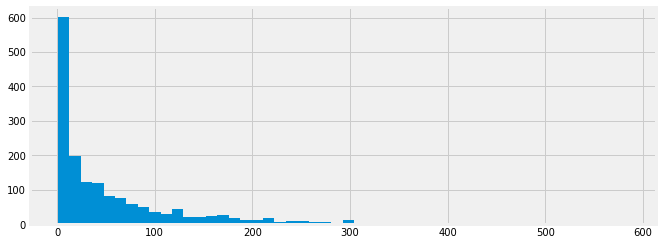

In [11]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=50)

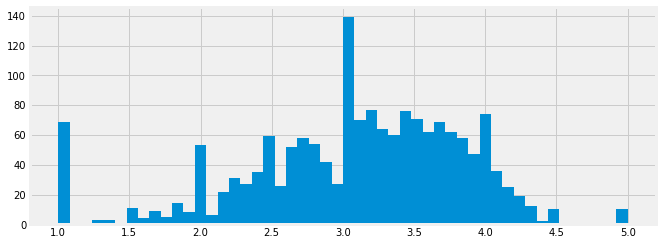

In [12]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=50)

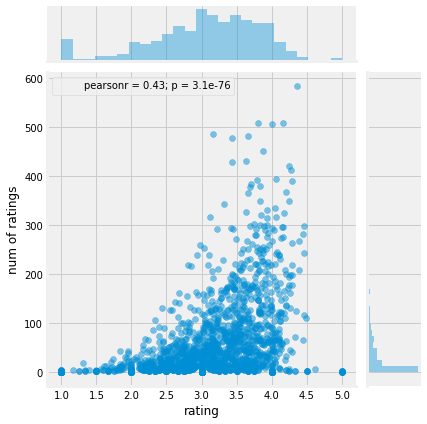

In [13]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

---

## Content based filtering

Content-based recommender systems focus on the attributes of the items and give you recommendations based on the similarity between them. It is based on the knowledge of the items, thus, all users in the system are mostly given the same set of recommendations.

* Recommending Similar Movies
    - create matrix that has user ids on one acess and the movie title on another axis.
    - each cell will consist of the rating the user gave to that movie.
    - Expect this to be sparse matrix as most people have not seen most of the movies.

In [14]:
movie_matrix = df.pivot_table(index='user_id',columns='title',values='rating')
movie_matrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


In [16]:
# Choose 2 movies and grab user ratings of them
starwars = movie_matrix['Star Wars (1977)']
contact = movie_matrix['Contact (1997)']

In [17]:
starwars.head(10)

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
5    4.0
6    4.0
7    5.0
8    5.0
9    5.0
Name: Star Wars (1977), dtype: float64

In [18]:
contact.head(10)

user_id
0    NaN
1    5.0
2    3.0
3    2.0
4    5.0
5    NaN
6    2.0
7    4.0
8    5.0
9    NaN
Name: Contact (1997), dtype: float64

In [19]:
import warnings
warnings.filterwarnings('ignore')
similar_to_starwars = movie_matrix.corrwith(starwars)
similar_to_contact = movie_matrix.corrwith(contact)

In [20]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns = ['Correlation'])
corr_starwars.dropna(inplace = True)
corr_starwars.head(10)
# This data frame index is the title of the movie and we have correlation column
# This correlation column tells us how correlated this specific movie's user ratings were 
# to user ratings of the starwars movie.
# theoretically by sorting this dataframe by correlation, we should be able to get the most 
# similar movies.

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398
2 Days in the Valley (1996),0.066654
"20,000 Leagues Under the Sea (1954)",0.289768
2001: A Space Odyssey (1968),0.230884
"39 Steps, The (1935)",0.106453


In [21]:
corr_starwars.sort_values('Correlation', ascending = False).head()
# These weird movies that we've never heard of is perfectly correlated with starwars (corr=1)
# Perhaps this was seen by 1 person who happened to watch starwars, rated 5 star.
# We can filter this by the number of the revies per movie.

,Correlation
title,
Hollow Reed (1996),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
Man of the Year (1995),1.0
"Beans of Egypt, Maine, The (1994)",1.0


In [22]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()
corr_starwars[corr_starwars['num of ratings'] > 100]\
.sort_values('Correlation', ascending = False).head(10)

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


In [23]:
corr_contact = pd.DataFrame(similar_to_contact, columns = ['Correlation'])
corr_contact.dropna(inplace = True)
corr_contact.sort_values('Correlation', ascending = False).head()

,Correlation
title,
Lamerica (1994),1.0
"Wedding Gift, The (1994)",1.0
"Visitors, The (Visiteurs, Les) (1993)",1.0
King of the Hill (1993),1.0
Contact (1997),1.0


In [24]:
corr_contact = corr_contact.join(ratings['num of ratings'])
corr_contact.head()
corr_contact[corr_contact['num of ratings'] > 100]\
.sort_values('Correlation', ascending = False).head(10)

,Correlation,num of ratings
title,,
Contact (1997),1.000000,509
Philadelphia (1993),0.446509,137
"Mask, The (1994)",0.418328,129
Young Guns (1988),0.388839,101
Sling Blade (1996),0.384840,136
Sneakers (1992),0.377275,150
"Firm, The (1993)",0.376987,151
Arsenic and Old Lace (1944),0.373759,115
Outbreak (1995),0.358015,104


---

## Collaborative Filtering

Collaborative Filtering(CF)  produces recommendations based on the knowledge of user interaction with the product/items. Collaborative filtering is done using two ways, one is Memory Based and other is Model based.

## Memory based Collaborative Filtering

Memory-Based Collaborative Filtering approaches can be divided into two main sections: 

    * user-item filtering: Users who are similar to you also liked ...
    * item-item filtering: Users who liked this item also liked...

A *user-item filtering* will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked.

In contrast, *item-item filtering* will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations.

We can create a user-item matrix which built from the entire dataset for both cases.  Since we have split the data into testing and training we will need to create two matrices (all users by all movies).  After we build the user-item matrix, we calculate the similarity and create a similarity matrix.

* The similarity values between items in Item-Item Collaborative Filtering are measured by observing all the users who have rated both items.

* The similarity values between users in User-Item Collaborative Filtering are measured by observing all the items that are rated by both users.


A distance metric commonly used in recommender systems is *cosine similarity*, where the ratings are seen as vectors in ``n``-dimensional space and the similarity is calculated based on the angle between these vectors. 
Cosine similiarity for users *a* and *m* can be calculated using the formula below, where you take dot product of  the user vector *$u_k$* and the user vector *$u_a$* and divide it by multiplication of the Euclidean lengths of the vectors.
<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(u_k,u_a)=\frac{u_k&space;\cdot&space;u_a&space;}{&space;\left&space;\|&space;u_k&space;\right&space;\|&space;\left&space;\|&space;u_a&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{k,m}x_{a,m}}{\sqrt{\sum&space;x_{k,m}^2\sum&space;x_{a,m}^2}}"/>

To calculate similarity between items *m* and *b* you use the formula:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(i_m,i_b)=\frac{i_m&space;\cdot&space;i_b&space;}{&space;\left&space;\|&space;i_m&space;\right&space;\|&space;\left&space;\|&space;i_b&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{a,m}x_{a,b}}{\sqrt{\sum&space;x_{a,m}^2\sum&space;x_{a,b}^2}}
"/>

The first step will be to create the user-item matrix. Since there are both testing and training data we need to create two matrices.  

In [32]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn import cross_validation as cv
# Split Data
train_data, test_data = cv.train_test_split(df, test_size=0.25)

In [33]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1] - 1, line[2] - 1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1] - 1, line[2] - 1] = line[3]

In [34]:
# Function set
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

def rmse(pred, actual):
    # Root Mean Squared Error. We will conside only non-zero ratings
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

def predict(ratings, similarity, type='user', epsilon=1e20):
    # Predict function to find user-user similarity and item-item similarity.
    # User bias is removed by adjusting the mean user bias before predicting ratings
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
    # You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

def top_k_movies_by_user(pred, mapper, user_idx, k=6):
    # Find the top-k movie names based on the ordered ratings
    return [mapper[x] for x in
            np.argsort(pred[user_idx, np.where(train_data_matrix[user_idx, :] == 0)[0]])[:-k - 1:-1]]

In [35]:
# Compute the cosine distance and 1-cosine distance yields cosine similarity.
# epsilon is used to handle the divide by zero scenarios
from sklearn.metrics.pairwise import pairwise_distances
epsilon = 1e-9

user_similarity = (1 - pairwise_distances(train_data_matrix, metric='cosine')) + epsilon
item_similarity = (1 - pairwise_distances(train_data_matrix.T, metric='cosine')) + epsilon

user_idx = 23

pred = predict(train_data_matrix, user_similarity, type='user')

user_base_train_rmse = rmse(pred, train_data_matrix)
user_base_test_rmse = rmse(pred, test_data_matrix)

trainRMSE = []
testRMSE = []

trainRMSE.append(user_base_train_rmse)
testRMSE.append(user_base_test_rmse)

In [36]:
print('User-based CF MSE on train data: ' + str(user_base_train_rmse))
print('User-based CF MSE on train data: ' + str(user_base_test_rmse) + "\n")
print("Movies recommended to user " + str(user_idx) + " are:")
nearestMovies = top_k_movies_by_user(pred, idx_to_movie, user_idx)
print(str(nearestMovies) + "\n")

pred = predict(train_data_matrix, item_similarity, type='item')

item_base_train_rmse = rmse(pred, train_data_matrix)
item_base_test_rmse = rmse(pred, test_data_matrix)
trainRMSE.append(item_base_train_rmse)
testRMSE.append(item_base_test_rmse)

print('Item-based CF MSE on test data: ' + str(item_base_train_rmse))
print('Item-based CF MSE on test data: ' + str(item_base_test_rmse) + "\n")
print("Movies recommended to user " + str(user_idx) + " are:")
nearestMovies = top_k_movies_by_user(pred, idx_to_movie, user_idx)
print(str(nearestMovies) + "\n")

User-based CF MSE on train data: 2.8971667291754892
User-based CF MSE on train data: 2.9605843380879424

Movies recommended to user 23 are:
['Disclosure (1994)', 'Fish Called Wanda, A (1988)', 'Jude (1996)', 'Toy Story (1995)', 'Ghost and the Darkness, The (1996)', 'Die Hard (1988)']

Item-based CF MSE on test data: 3.0982385626749713
Item-based CF MSE on test data: 3.1674370062761388

Movies recommended to user 23 are:
['Denise Calls Up (1995)', 'Party Girl (1995)', 'Hostile Intentions (1994)', 'Reluctant Debutante, The (1958)', 'King of New York (1990)', 'Shopping (1994)']



---

## Model based Collaborative filtering

Model based collaborative filtering uses matrix factorization methods to find the hidden features from the given data.  Singular Value Decomposition(SVD) is one such matrix factorization methods which we will explore below.  We will use the SVD as the matrix factorization method to find the features in the vector space.

In [37]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds
 
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 30)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
 
model_base_train_rmse = rmse(X_pred, train_data_matrix)
model_base_test_rmse = rmse(X_pred, test_data_matrix)
trainRMSE.append(model_base_train_rmse)
testRMSE.append(model_base_test_rmse)
 
print('Model-based CF MSE on train data: ' + str(model_base_train_rmse))
print('Model-based CF MSE on test data: ' + str(model_base_test_rmse) + "\n")
 
print("Movies recommended to user " + str(user_idx) + " are:")
nearestMovies = top_k_movies_by_user(X_pred, idx_to_movie, user_idx)
print(str(nearestMovies) + "\n")
 
# Compare true ratings of user with predictions
ratings = pd.DataFrame(columns = ("Actual Rating","Predicted Rating"))
ratings["Actual Rating"] = train_data_matrix[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
ratings["Predicted Rating"] = X_pred[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
print(ratings)

Model-based CF MSE on train data: 2.275651649503797
Model-based CF MSE on test data: 2.805839037298546

Movies recommended to user 23 are:
['Quiz Show (1994)', 'Jude (1996)', 'From Dusk Till Dawn (1996)', 'To Kill a Mockingbird (1962)', 'Fish Called Wanda, A (1988)', 'Richard III (1995)']

   Actual Rating  Predicted Rating
0            4.0          3.130919
1            5.0          1.693540
2            5.0          2.887540
3            5.0          2.161030
4            5.0          4.377597


It appears that the Model based collaborative filtering does not perform any better than the memory based model.  Another issue to notice is that the matrix factorization approach does not work well with missing data.

---

## Model performance Evaluation

Here is a simple lot to compare RMSE of all four that we have performed above.

* Content based
* Memory based CF(user based)
* Memory based CF(item based)
* Model Based CF(Singular Value Decomposition(SVD)

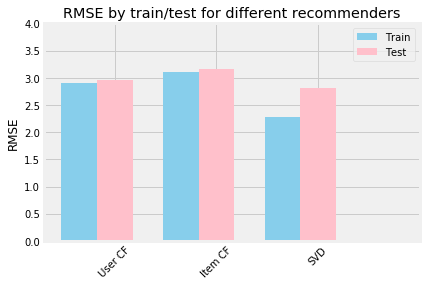

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
 
## the data
N = 3

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars
 
## the bars
rects1 = ax.bar(ind, trainRMSE, width,
color='skyblue'
)
 
rects2 = ax.bar(ind+width, testRMSE, width,
color='pink',
)
 
# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,4)
ax.set_ylabel('RMSE')
ax.set_title('RMSE by train/test for different recommenders')
xTickMarks = ['User CF','Item CF','SVD']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)
## add a legend
ax.legend( (rects1[0], rects2[0]), ('Train', 'Test') )
plt.show()

---

## Conclusion
All the above models adopt different techniques to predict the movie ratings based on the existing data.  Model performance is guaged with least Root Mean Square Error.  SVD outperforms other collaborative filtering methods with the least Root Mean Squared Error.

---